<a href="https://colab.research.google.com/github/Juricasfi/IA/blob/main/Prediccion_precio_casas_Dropout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow.keras.datasets import boston_housing

(train_data, train_target),(test_data, test_targets) = (boston_housing.load_data())

57026/57026 [==============================] - 0s 0us/step


In [ ]:
## debido a que los datos tienen rangos diferentes se realiza una normalización de los datos,
## a los datos se les resta la media y se divide en la desviación estandar

import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

mean = train_data.mean(axis = 0)
train_data -= mean
std = train_data.std(axis = 0)
train_data /= std
test_data -= mean
test_data /= std


# Se realiza el modelo con la capa final con solo una unidad y sin función de activación, esto por que es un modelo de predicción
# y se necesita que el resultado sea un escalar, si se coloca una función de activación no retornara un valor correcto

def build_model():
 model = keras.Sequential([
 layers.Dense(64, activation="relu"),
 layers.Dense(64, activation="relu"),
 layers.Dense(1)
 ])
 model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
 return model

In [ ]:
## Ya que hay pocos datos re realiza la validacion cruzada K-fold

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
 print(f"Processing fold #{i}")
 val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
 val_targets = train_target[i * num_val_samples: (i + 1) * num_val_samples]
 partial_train_data = np.concatenate(
 [train_data[:i * num_val_samples],
 train_data[(i + 1) * num_val_samples:]],
 axis=0)
 partial_train_targets = np.concatenate(
  [train_target[:i * num_val_samples],
  train_target[(i + 1) * num_val_samples:]],
  axis=0)
 model = build_model()
 model.fit(partial_train_data, partial_train_targets,
 epochs=num_epochs, batch_size=16, verbose=0)
 val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
 all_scores.append(val_mae)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


In [ ]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
 print(f"Processing fold #{i}")
 val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
 val_targets = train_target[i * num_val_samples: (i + 1) * num_val_samples]
 partial_train_data = np.concatenate(
 [train_data[:i * num_val_samples],
 train_data[(i + 1) * num_val_samples:]],
 axis=0)
 partial_train_targets = np.concatenate(
 [train_target[:i * num_val_samples],
 train_target[(i + 1) * num_val_samples:]],
 axis=0)
 model = build_model()
 history = model.fit(partial_train_data, partial_train_targets,
 validation_data=(val_data, val_targets),
 epochs=num_epochs, batch_size=16, verbose=0)
 mae_history = history.history["val_mae"]
 all_mae_histories.append(mae_history)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


In [ ]:
## Average per epoch


average_mae_history = [
 np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

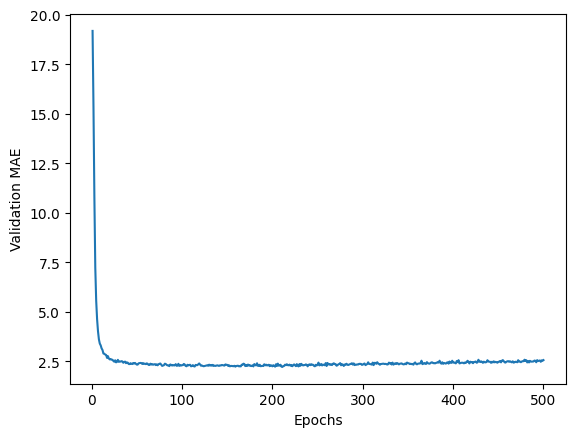

In [ ]:
#plot validation Scores
import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

Reguladores de capas

 L1 regularization—The cost added is proportional to the absolute value of the
weight coefficients (the L1 norm of the weights).
 L2 regularization—The cost added is proportional to the square of the value of the
weight coefficients (the L2 norm of the weights).

L2 regularization is also called
weight decay in the context of neural networks. Don’t let the different name confuse you: weight decay is mathematically the same as L2 regularization.

In [ ]:
from tensorflow.keras import regularizers
model = keras.Sequential([
 layers.Dense(16,
 kernel_regularizer=regularizers.l2(0.002),  ## Regula la cantidad de capas(cada peso se multiplica por 0.002*peso del coeficiente^2)
 activation="relu"),
 layers.Dense(16,
 kernel_regularizer=regularizers.l2(0.002),## hay l o l1  regularizers.l1(0.002)
 activation="relu"),
 layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer="rmsprop",
 loss="binary_crossentropy",
 metrics=["accuracy"])
history_l2_reg = model.fit(
 train_data, train_labels,
 epochs=20, batch_size=512, validation_split=0.4)

Dropout

Eliminar aleatoriamente un archivo diferente
Un subconjunto de neuronas en cada ejemplo evitaría conspiraciones y, por lo tanto, reduciría el ajuste excesivo”. La idea central es que introducir ruido en los valores de salida de una capa puede
romper patrones fortuitos que no son significativos (lo que Hinton llama conspiraciones), que el modelo comenzará a memorizar si no hay ruido presente.

In [ ]:
model = keras.Sequential([
 layers.Dense(16, activation="relu"),
 layers.Dropout(0.5),                     ## drop 50%
 layers.Dense(16, activation="relu"),
 layers.Dropout(0.5),
 layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
 loss="binary_crossentropy",
 metrics=["accuracy"])
history_dropout = model.fit(
 train_data, train_labels,
 epochs=20, batch_size=512, validation_split=0.4)